In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                           explained_variance_score, mean_absolute_percentage_error)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from joblib import dump

In [2]:
df = pd.read_csv('..\\data\\cleaned\\data.csv')

min_count = 10
city_counts = df['city'].value_counts()
df['city'] = df['city'].apply(lambda x: 'Other' if city_counts[x] < min_count else x)

X = df[['area', 'rooms', 'floor', 'city']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (9363, 4)
Test set shape: (2341, 4)


In [3]:
numeric_features = ['area', 'rooms', 'floor']
categorical_features = ['city']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Linear regression

In [4]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

start_time = time.time()

model.fit(X_train, y_train)

training_time = time.time() - start_time

In [5]:
prediction_start_time = time.time()
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
prediction_time = time.time() - prediction_start_time

metrics = {
    'R2 Score (Train)': r2_score(y_train, y_pred_train),
    'R2 Score (Test)': r2_score(y_test, y_pred_test),
    
    'RMSE (Train)': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'RMSE (Test)': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    
    'MAE (Train)': mean_absolute_error(y_train, y_pred_train),
    'MAE (Test)': mean_absolute_error(y_test, y_pred_test),
    
    'Explained Variance (Train)': explained_variance_score(y_train, y_pred_train),
    'Explained Variance (Test)': explained_variance_score(y_test, y_pred_test),
    
    'MAPE (Train)': mean_absolute_percentage_error(y_train, y_pred_train) * 100,
    'MAPE (Test)': mean_absolute_percentage_error(y_test, y_pred_test) * 100,
    
    'Mean Relative Error (Train)': np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100,
    'Mean Relative Error (Test)': np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100,
}

timing_metrics = {
    'Training Time (seconds)': training_time,
    'Prediction Time (seconds)': prediction_time,
    'Average Prediction Time per Sample (ms)': (prediction_time / len(X_test)) * 1000
}

print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:,.2f}")



Model Performance Metrics:
R2 Score (Train): 0.67
R2 Score (Test): 0.60
RMSE (Train): 88,102.65
RMSE (Test): 68,799.77
MAE (Train): 47,617.91
MAE (Test): 44,265.15
Explained Variance (Train): 0.67
Explained Variance (Test): 0.60
MAPE (Train): 32.73
MAPE (Test): 33.35
Mean Relative Error (Train): 32.73
Mean Relative Error (Test): 33.35


In [6]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
cv_metrics = {
    'Cross-Validation Mean R2': cv_scores.mean(),
    'Cross-Validation Std R2': cv_scores.std()
}

In [7]:
print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)

print("\nBasic Metrics:")
for metric in ['R2 Score', 'RMSE', 'MAE']:
    print(f"\n{metric}:")
    print(f"  Train: {metrics[f'{metric} (Train)']:,.3f}")
    print(f"  Test:  {metrics[f'{metric} (Test)']:,.3f}")

print("\nAdvanced Metrics:")
print(f"Explained Variance (Train): {metrics['Explained Variance (Train)']:,.3f}")
print(f"Explained Variance (Test):  {metrics['Explained Variance (Test)']:,.3f}")
print(f"MAPE (Train): {metrics['MAPE (Train)']:,.2f}%")
print(f"MAPE (Test):  {metrics['MAPE (Test)']:,.2f}%")
print(f"Mean Relative Error (Train): {metrics['Mean Relative Error (Train)']:,.2f}%")
print(f"Mean Relative Error (Test):  {metrics['Mean Relative Error (Test)']:,.2f}%")

print("\nCross-Validation Metrics:")
print(f"Mean R2: {cv_metrics['Cross-Validation Mean R2']:,.3f} (±{cv_metrics['Cross-Validation Std R2']:,.3f})")

print("\nTiming Metrics:")
for metric, value in timing_metrics.items():
    print(f"{metric}: {value:,.4f}")


MODEL PERFORMANCE METRICS

Basic Metrics:

R2 Score:
  Train: 0.668
  Test:  0.602

RMSE:
  Train: 88,102.650
  Test:  68,799.767

MAE:
  Train: 47,617.906
  Test:  44,265.148

Advanced Metrics:
Explained Variance (Train): 0.668
Explained Variance (Test):  0.603
MAPE (Train): 32.73%
MAPE (Test):  33.35%
Mean Relative Error (Train): 32.73%
Mean Relative Error (Test):  33.35%

Cross-Validation Metrics:
Mean R2: 0.636 (±0.020)

Timing Metrics:
Training Time (seconds): 0.0217
Prediction Time (seconds): 0.0091
Average Prediction Time per Sample (ms): 0.0039


In [8]:
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

print("\nResidual Statistics:")
print("\nTraining Set:")
print(f"Mean Residual: {residuals_train.mean():,.2f}")
print(f"Residual Std: {residuals_train.std():,.2f}")
print("\nTest Set:")
print(f"Mean Residual: {residuals_test.mean():,.2f}")
print(f"Residual Std: {residuals_test.std():,.2f}")


Residual Statistics:

Training Set:
Mean Residual: -0.00
Residual Std: 88,107.36

Test Set:
Mean Residual: -3,316.94
Residual Std: 68,734.45


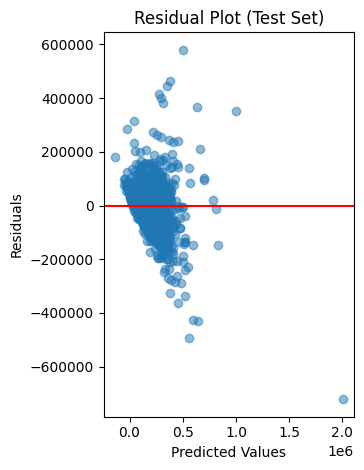

In [9]:
plt.subplot(122)
plt.scatter(y_pred_test, residuals_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')
plt.axhline(y=0, color='r', linestyle='-')

plt.tight_layout()
plt.show()

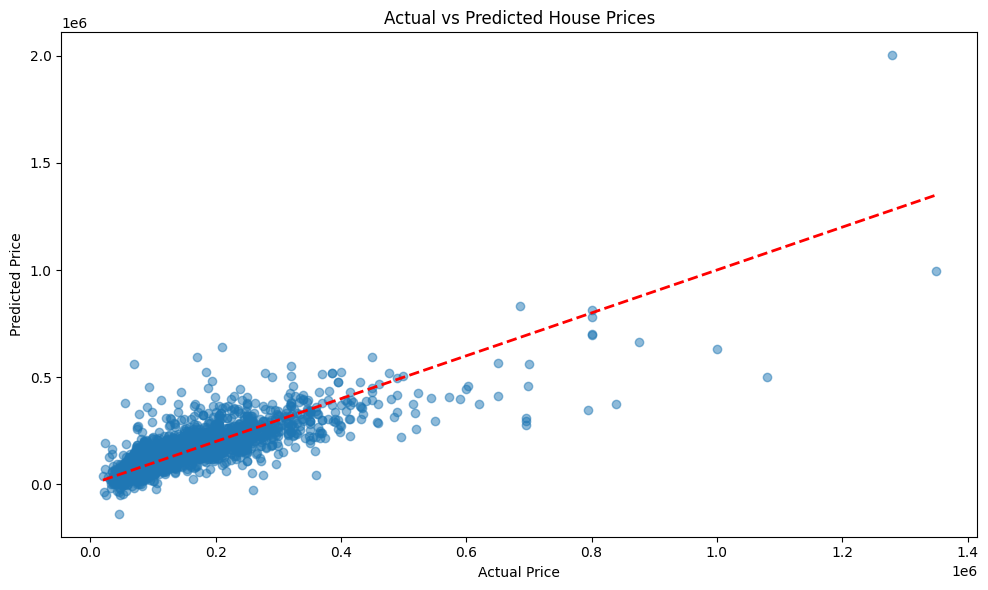

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices')
plt.tight_layout()
plt.show()


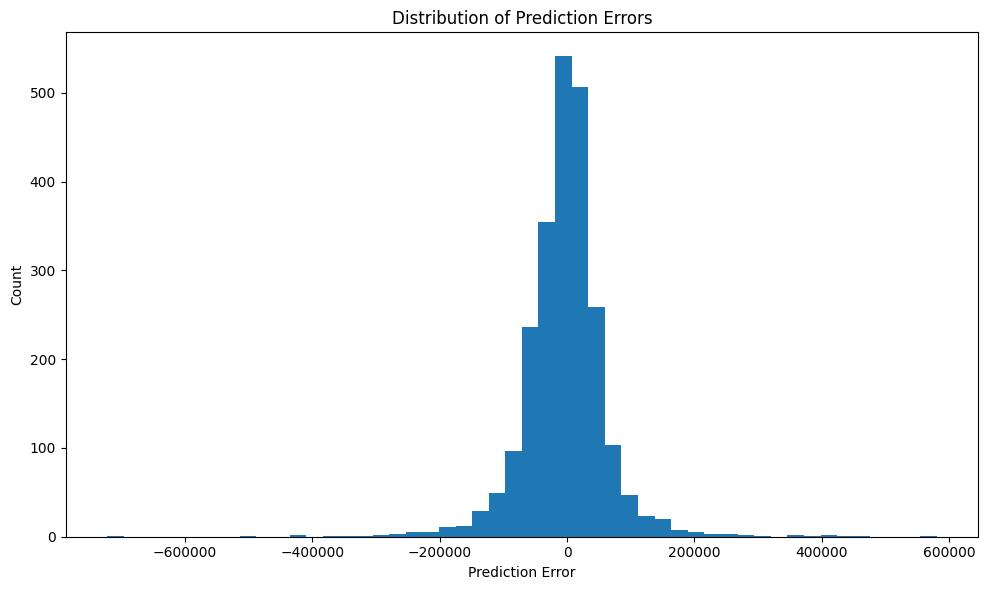

In [11]:
errors = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

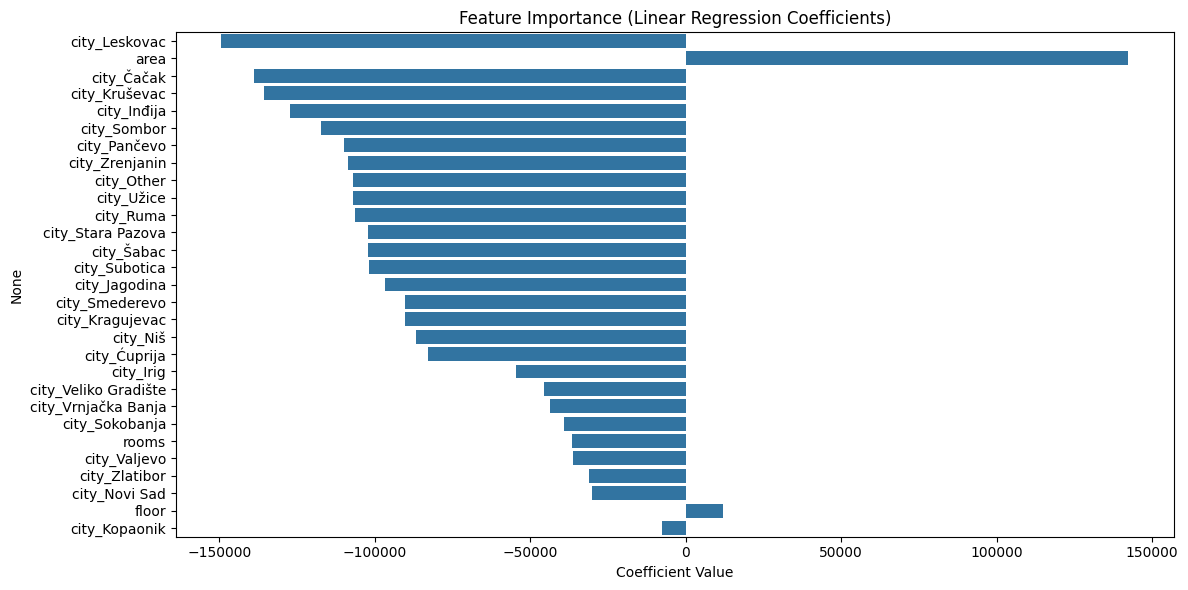

In [12]:
feature_names = (
    numeric_features + 
    [f"{cat}" for cat in model.named_steps['preprocessor']
     .named_transformers_['cat'].get_feature_names_out(['city'])]
)

coefficients = pd.DataFrame(
    model.named_steps['regressor'].coef_,
    index=feature_names,
    columns=['Coefficient']
)

coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=coefficients['Coefficient'], y=coefficients.index)
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()


In [13]:
print("\nTop 10 Most Important Features:")
print(coefficients.head(10))


Top 10 Most Important Features:
                  Coefficient  Abs_Coefficient
city_Leskovac  -149315.502769    149315.502769
area            142335.534487    142335.534487
city_Čačak     -138801.577719    138801.577719
city_Kruševac  -135490.626632    135490.626632
city_Inđija    -127246.319345    127246.319345
city_Sombor    -117222.820182    117222.820182
city_Pančevo   -109796.089644    109796.089644
city_Zrenjanin -108615.217755    108615.217755
city_Other     -107054.174854    107054.174854
city_Užice     -106903.171427    106903.171427


In [14]:
percentage_errors = (abs(y_test - y_pred_test) / y_test) * 100
print("\nPercentage Error Statistics:")
print(f"Mean percentage error: {percentage_errors.mean():.2f}%")
print(f"Median percentage error: {percentage_errors.median():.2f}%")
print(f"90th percentile of percentage error: {np.percentile(percentage_errors, 90):.2f}%")


Percentage Error Statistics:
Mean percentage error: 33.35%
Median percentage error: 22.97%
90th percentile of percentage error: 69.01%


In [15]:
dump(model, '..\\models\\linear_regression_model.joblib')

with open('..\\models\\linear_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

## Random Forest

In [ ]:
df = pd.read_csv('..\\data\\cleaned\\data.csv')

